In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [3]:
from neuron import h
h.load_file("stdrun.hoc");

In [4]:
from glob import glob
#cellhocs = sorted(glob('Cell_*.hoc'))
cellhocs = sorted(glob('Cell_0.hoc'))

In [5]:
simtime = 1000
stim_start = simtime / 2
stim_end = simtime
amp = 0.010

In [6]:
def breadth(sec):
    return len(sec.subtree())

def is_terminal(sec):
    return breadth(sec) == 1

def is_stem(sec):
    return 'soma' in str(sec.parentseg()) and not 'soma' in sec.name()

def get_terminals(sec):
    return [s for s in sec.subtree() if is_terminal(s)]

def get_stems(sec):
    return [s for s in sec.wholetree() if is_stem(s)]

In [7]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [8]:
def make_cell(hoc, morph=None):
    h.load_file(hoc)
    name = hoc.split('.')[0]
    if morph:
        cmd = f'h.{name}("../morphology/", "{morph}")'
    else:
        cmd = f'h.{name}("../morphology/")'  # default morphology
    cell = eval(cmd)
    return cell

In [9]:
def make_nterm_cells(hoc, morph=None):
    cell = make_cell(hoc, morph)
    nterm = len([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
    cells = [make_cell(hoc, morph) for i in range(nterm)]
    return cells

In [10]:
def set_term_stim(amp, cells):
    stimuli = []
    for i, cell in enumerate(cells):
        dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        tip = dend_tips[i]
        stim = h.IClamp(tip(1.0))
        stim.amp = amp
        stim.delay = stim_start
        stim.dur = stim_end - stim_start
        stimuli.append(stim)
    return stimuli

In [11]:
def get_term_volts(cells):
    volts = []
    for i, cell in enumerate(cells):
        dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        volt = h.Vector()
        volt.record(dend_tips[i](1.0)._ref_v)
        volts.append(volt)
    return volts

In [12]:
def get_soma_volts(cells):
    volts = []
    for i, cell in enumerate(cells):
        volt = h.Vector()
        volt.record(cell.soma[0](0.5)._ref_v)
        volts.append(volt)
    return volts

In [13]:
allcells = []
for cellhoc in cellhocs:
    allcells.append(make_nterm_cells(cellhoc))
    print(len(allcells[-1]))
#allcells

35


In [14]:
allstim = []
for cells in allcells:
    stimuli = set_term_stim(amp, cells)
    allstim.append(stimuli)

In [15]:
allvolts = []
allsoma_volts = []
for cells in allcells:
    volts = get_term_volts(cells)
    soma_volts = get_soma_volts(cells)
    allvolts.append(volts)
    allsoma_volts.append(soma_volts)

In [16]:
time = h.Vector()
time.record(h._ref_t)

Vector[19112]

In [17]:
%%time
h.v_init = -92.5
h.celsius = 35
h.tstop = simtime
cvode = h.CVode()
cvode.active(True)
h.run()

CPU times: user 6.1 s, sys: 26.8 ms, total: 6.12 s
Wall time: 6.1 s


0.0

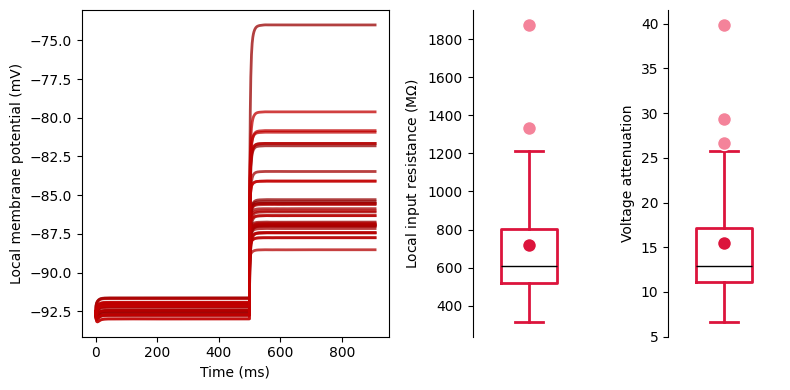

In [18]:
fig = plt.figure(figsize=(8, 4))

gs = fig.add_gridspec(1, 4)
ax = fig.add_subplot(gs[:2])

rin = []
att = []
color = 'darkred'
for volts, soma_volts in zip(allvolts, allsoma_volts):
    for volt, soma_volt in zip(volts, soma_volts):
        ax.plot(time, volt, color=color, linewidth=2, alpha=0.75)
        color = lighten_color(color, 0.995)
        t = np.array(time)
        v = np.array(volt)
        s = np.array(soma_volt)
        sel = (t > simtime/2 *0.5) * (t < simtime/2)
        v1 = v[sel].mean()
        s1 = s[sel].mean()
        sel = (t > simtime *0.75)
        v2 = v[sel].mean()
        s2 = s[sel].mean()
        rin.append(abs((v2 - v1) / amp))
        att.append(abs((v2 - v1) / (s2 - s1)))

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Local membrane potential (mV)')

ax = fig.add_subplot(gs[2:3])

meanprops = dict(marker='o', markersize=10, markerfacecolor='crimson', markeredgecolor='w')
medianprops = dict(color='k')
flierprops = dict(marker='o', markerfacecolor=lighten_color('crimson'), markersize=10, markeredgecolor='w')
capprops = dict(color='crimson', linewidth=2)
boxprops = dict(color='crimson', linewidth=2)
whiskerprops = dict(color='crimson', linewidth=2)
ax.boxplot(rin, showmeans=True, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Local input resistance (M$\Omega$)')

ax = fig.add_subplot(gs[3:4])

ax.boxplot(att, showmeans=True, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Voltage attenuation')

fig.tight_layout()
fig.savefig('images/test5-rin-1.pdf')

In [19]:
def get_space_constants(cell, sections=[], neurite_type='dend', R_pas=None, R_ax=None):
    space_constants = []
    if not sections:
        stems = sorted([s for s in get_stems(cell.soma[0]) if neurite_type in s.name()])
        sections = [sec for stem in stems for sec in stem.subtree()[1:]]
    for sec in sections:
        #parent = sec.parentseg().sec
        d = sec(0.5).diam  # um
        g = sec.psection()['density_mechs']['pas']['g'][0]
        Ri = R_ax if R_ax else sec.Ra  # Ohm*cm
        Rm = R_pas if R_pas else (1 / g)  # Ohm*cm2
        lam = np.sqrt((d * Rm) / (4 * Ri) * 1e4)  # um
        #print(f'{d=}, {g=}, {Ri=}, {Rm=}, {lam=}')
        space_constants.append(lam)
    return space_constants

In [20]:
def get_seclengths(cell, sections=[], neurite_type='dend'):
    seclengths = []
    if not sections:
        stems = sorted([s for s in get_stems(cell.soma[0]) if neurite_type in s.name()])
        sections = [sec for stem in stems for sec in stem.subtree()[1:]]
    for sec in sections:
        L = sec.L
        seclengths.append(L)
    return seclengths

In [21]:
seclengths = []
space_constants = []
space_constants_ref = []
for cells in allcells:
    for cell in cells:
        terminals = [sec for sec in get_terminals(cell.soma[0])]
        space_constants.extend(get_space_constants(cell, sections=terminals, neurite_type='dend'))
        space_constants_ref.extend(get_space_constants(cell, sections=terminals, neurite_type='dend', R_pas=15000))
        seclengths.extend(get_seclengths(cell, sections=terminals, neurite_type='dend'))
seclengths = np.array(seclengths)
space_constants = np.array(space_constants)
space_constants_ref = np.array(space_constants_ref)

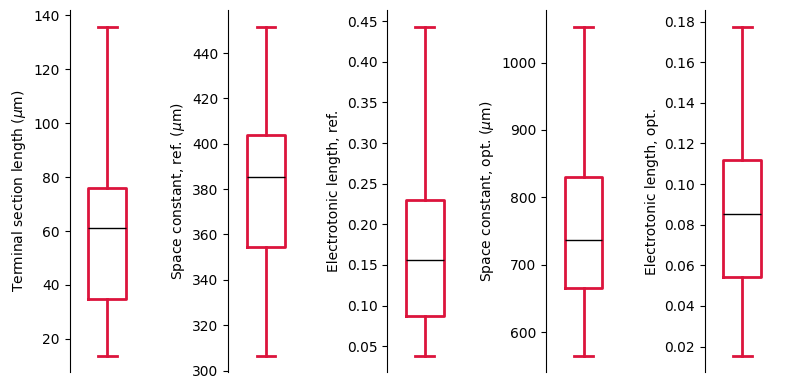

In [22]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 5, 1)

ax.boxplot(seclengths, showmeans=False, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Terminal section length ($\mu$m)')

ax = fig.add_subplot(1, 5, 2)

ax.boxplot(space_constants_ref, showmeans=False, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops, showfliers=False)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Space constant, ref. ($\mu$m)')

ax = fig.add_subplot(1, 5, 3)

ax.boxplot(seclengths / space_constants_ref, showmeans=False, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops, showfliers=False)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Electrotonic length, ref.')

ax = fig.add_subplot(1, 5, 4)

ax.boxplot(space_constants, showmeans=False, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops, showfliers=False)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Space constant, opt. ($\mu$m)')

ax = fig.add_subplot(1, 5, 5)

ax.boxplot(seclengths / space_constants, showmeans=False, widths=0.5, 
           boxprops=boxprops, whiskerprops=whiskerprops, meanprops=meanprops, medianprops=medianprops, 
           flierprops=flierprops, capprops=capprops, showfliers=False)

ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Electrotonic length, opt.')

fig.tight_layout()
fig.savefig('images/test5-rin-2.pdf')

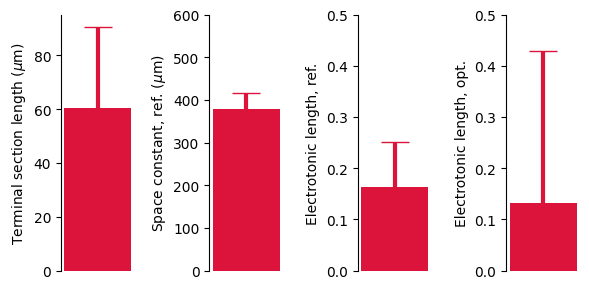

In [23]:
fig = plt.figure(figsize=(6, 3))

color = 'crimson'

ax = fig.add_subplot(1, 4, 1)
ax.bar(0, seclengths.mean(), color=color)
ax.errorbar(0, seclengths.mean(), yerr=seclengths.std(), capsize=10, linewidth=3, color=color)
ax.set_ylim(bottom=0)
ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Terminal section length ($\mu$m)')

ax = fig.add_subplot(1, 4, 2)
ax.bar(0, space_constants_ref.mean(), color=color)
ax.errorbar(0, space_constants_ref.mean(), yerr=space_constants_ref.std(), capsize=10, linewidth=3, color=color)
ax.set_ylim(bottom=0, top=600)
ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Space constant, ref. ($\mu$m)')

ax = fig.add_subplot(1, 4, 3)
ax.bar(0, (seclengths / space_constants_ref).mean(), color=color)
ax.errorbar(0, (seclengths / space_constants_ref).mean(), yerr=(seclengths / space_constants_ref).std(), 
            capsize=10, linewidth=3, color=color)
ax.set_ylim(bottom=0, top=0.5)
ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Electrotonic length, ref.')

ax = fig.add_subplot(1, 4, 4)
ax.bar(0, (seclengths / space_constants).mean(), color=color)
ax.errorbar(0, (seclengths / space_constants).mean(), yerr=(seclengths / space_constants).std(), 
            capsize=10, linewidth=3, color=color)
ax.set_ylim(bottom=0, top=0.5)
ax.set_xticks([])
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_ylabel('Electrotonic length, opt.')

fig.tight_layout()
fig.savefig('images/test5-rin-3.pdf')